# Training and evaluation of model for PAI-scoring
2024.05.31 Gerald Torgersen
# Model: ResNet-50
# Data
- csv files with column for filename, PAI, weight
- RGB clips of radiographs centered around apex, 224 x 224 pixels

The weight in the data refers to the quality of scoring.

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import resnet50
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from PIL import Image
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Normalize class labels to 0-based
        self.data['PAI'] = self.data['PAI'] - 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['filename']
        root_dir = self.data.iloc[idx]['root_dir']
        img_path = os.path.join(root_dir, img_name)
        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
        else:
            raise FileNotFoundError(f"Image {img_name} not found in the root directory.")

        label = self.data.iloc[idx]['PAI']
        weight = self.data.iloc[idx]['weight']

        if self.transform:
            image = self.transform(image)

        return image, label, weight

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            print(f'Validation loss improved to {val_loss:.4f}, resetting counter.')
            return False
        else:
            self.counter += 1
            print(f'Validation loss did not improve. Counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True
            return False

# Function to save the checkpoint
def save_checkpoint(model, optimizer, epoch, filename):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, filename)

# Function to load the checkpoint
def load_checkpoint(model, optimizer, filename):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        return model, optimizer, start_epoch
    else:
        raise FileNotFoundError

# Enhanced data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.37887412, 0.37887412, 0.37887412], std=[0.09176591, 0.09176591, 0.09176591])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.37887412, 0.37887412, 0.37887412], std=[0.09176591, 0.09176591, 0.09176591])
    ]),
}

In [ ]:
# Load and combine data one ore more datasets
all_data = pd.DataFrame()
csv_files = ["path1/data1.csv", "path2/data2.csv"] # Replace with your csv paths
root_dirs = ["images_path1", "images_path2"] # Replace with your image paths

for csv_file, root_dir in zip(csv_files, root_dirs):
    data = pd.read_csv(csv_file)
    data['root_dir'] = root_dir  # Add the root directory to the dataframe
    all_data = pd.concat([all_data, data], ignore_index=True)

# Split the combined dataset into training and validation sets
train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=42, stratify=all_data['PAI'])

In [ ]:
# Handle unbalanced data by ramdom oversampling

from imblearn.over_sampling import RandomOverSampler

# Separate features and target for SMOTE
X_train = train_data.drop(columns=['PAI'])
y_train = train_data['PAI']

# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and target
train_data_balanced = pd.concat([X_resampled, y_resampled], axis=1)

# Verify class distribution
print('Class distribution after oversampling:')
print(train_data_balanced['PAI'].value_counts())

# Create training and validation datasets
train_dataset = CustomDataset(train_data_balanced, transform=data_transforms['train'])
val_dataset = CustomDataset(val_data, transform=data_transforms['val'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Class distribution after oversampling:
PAI
4    372
5    372
3    372
2    372
1    372
Name: count, dtype: int64
Training dataset size: 1860
Validation dataset size: 225


In [ ]:
from collections import Counter

# Function to display dataset statistics
def display_dataset_statistics(data, name):
    class_counts = Counter(data['PAI'])
    total_samples = len(data)
    class_percentages = {cls: count / total_samples * 100 for cls, count in class_counts.items()}

    stats_df = pd.DataFrame({
        'Class': list(class_counts.keys()),
        'Count': list(class_counts.values()),
        'Percentage (%)': [f"{percentage:.1f}" for percentage in class_percentages.values()]
    })

    print(f"\nStatistics for {name} set:")
    print(stats_df)

# Display statistics for training and validation sets
display_dataset_statistics(train_data_balanced, 'Training')  # Using the balanced training data
display_dataset_statistics(val_data, 'Validation')



Statistics for Training set:
   Class  Count Percentage (%)
0      3    372           20.0
1      4    372           20.0
2      2    372           20.0
3      1    372           20.0
4      0    372           20.0

Statistics for Validation set:
   Class  Count Percentage (%)
0      0     46           20.4
1      2     93           41.3
2      3     37           16.4
3      1     38           16.9
4      4     11            4.9


In [ ]:
# Load ResNet-50
model = resnet50(pretrained=True)
num_features = model.fc.in_features

# Adjust the final fully connected layer with dropout
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout layer
    nn.Linear(num_features, 5)  # Assuming 5 classes
)


# Unlock the last two layers and the classifier
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:  # Adjust to unfreeze more layers if needed
        param.requires_grad = True
    else:
        param.requires_grad = False

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Lists to collect training data
train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []
mae_list = []

In [ ]:
import time  # Import time to measure the duration of each epoch
import torch.nn.functional as F

# Path to save the checkpoint
check_point_path = 'ResNet50_model_checkpoint.pth'

# Initialize start_epoch and total_epochs
start_epoch = 0
total_epochs = 40

# Attempt to load checkpoint
try:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, check_point_path)
    total_epochs = start_epoch + 10
except FileNotFoundError:
    start_epoch = 0
    total_epochs = 40
    print("No checkpoint found. Starting training from scratch.")

# Lists to store the probabilities for each class
all_probs = []
all_true_labels = []

for epoch in range(start_epoch, total_epochs):
    epoch_start_time = time.time()  # Start timing the epoch
    print(f'Starting epoch {epoch+1}/{total_epochs}')

    train_loss = 0.0
    train_corrects = 0
    val_loss = 0.0
    val_corrects = 0

    model.train()
    for batch_idx, (inputs, labels, _) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)

    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, labels, _) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

            # Collect true labels and probabilities for each class
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())


    mae = mean_absolute_error(all_true_labels, [np.argmax(p) for p in all_probs])
    mae_list.append(mae)

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_corrects.double() / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch+1}/{total_epochs} - '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}, '
          f'MAE: {mae:.4f}')

    save_checkpoint(model, optimizer, epoch + 1, check_point_path)

    if early_stopping(val_loss):
        print("Early stopping")
        break

    scheduler.step()

No checkpoint found. Starting training from scratch.
Starting epoch 1/40
Epoch 1/40 - Train Loss: 1.4610, Train Accuracy: 0.3484, Validation Loss: 1.7783, Validation Accuracy: 0.2178, MAE: 1.0933
Validation loss improved to 1.7783, resetting counter.
Starting epoch 2/40
Epoch 2/40 - Train Loss: 1.0885, Train Accuracy: 0.5376, Validation Loss: 1.4965, Validation Accuracy: 0.3511, MAE: 1.0622
Validation loss improved to 1.4965, resetting counter.
Starting epoch 3/40
Epoch 3/40 - Train Loss: 0.8593, Train Accuracy: 0.6425, Validation Loss: 1.4352, Validation Accuracy: 0.4133, MAE: 0.9837
Validation loss improved to 1.4352, resetting counter.
Starting epoch 4/40
Epoch 4/40 - Train Loss: 0.6802, Train Accuracy: 0.7355, Validation Loss: 1.5566, Validation Accuracy: 0.4222, MAE: 0.9344
Validation loss did not improve. Counter: 1/10
Starting epoch 5/40
Epoch 5/40 - Train Loss: 0.5540, Train Accuracy: 0.7941, Validation Loss: 1.5971, Validation Accuracy: 0.4356, MAE: 0.9067
Validation loss did 

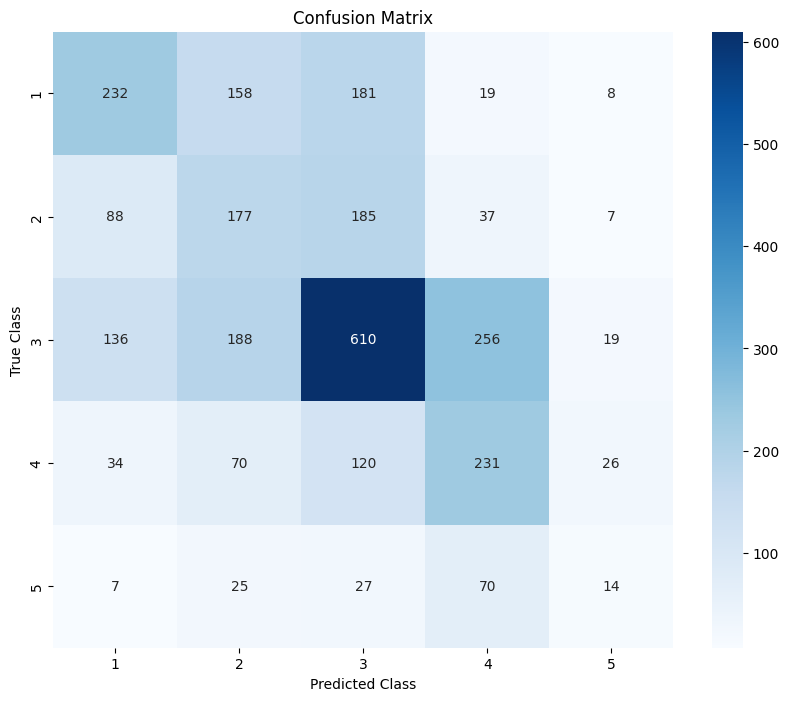

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

num_classes = 5

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, [np.argmax(p) for p in all_probs])

# Adjust the labels to start from 1 instead of 0
labels = range(1, num_classes + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


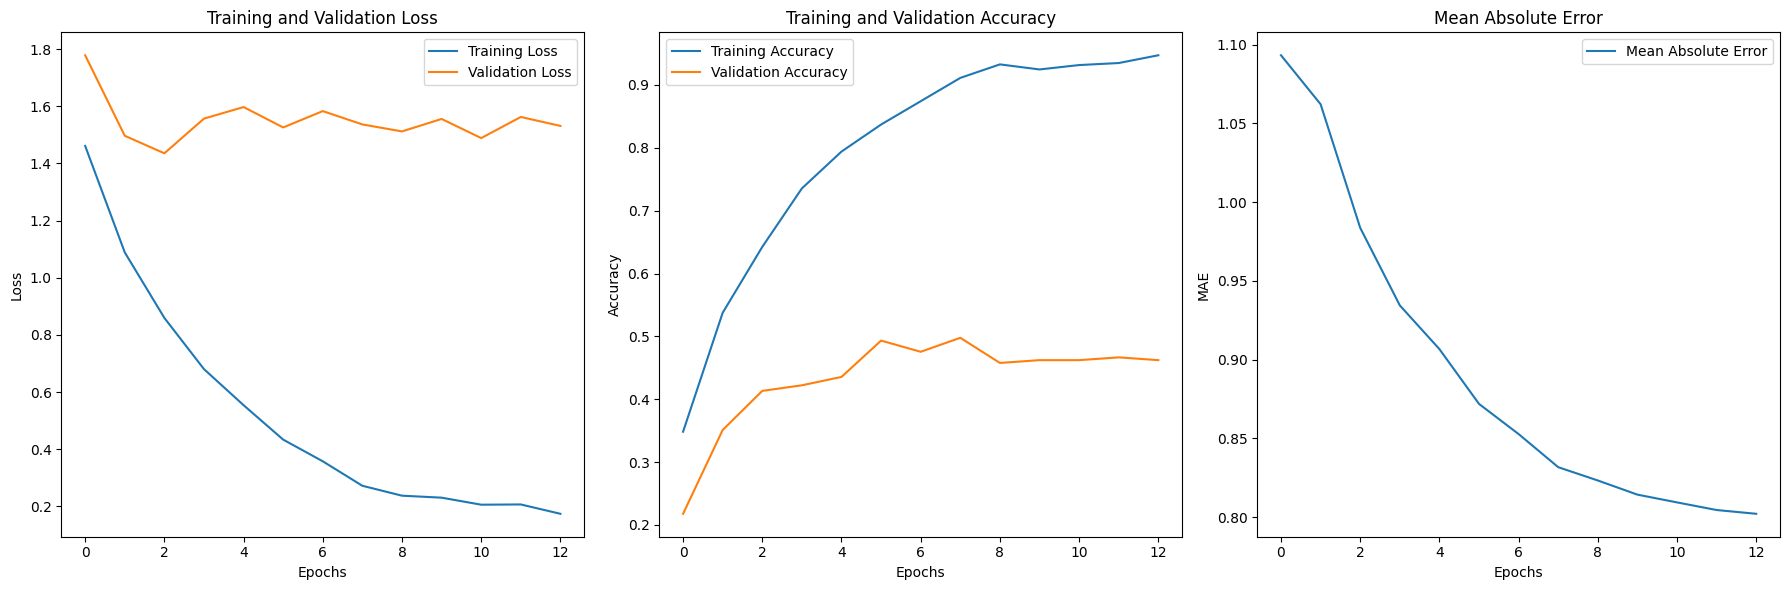

In [ ]:
# Ensure all elements are floats
train_loss_list = [loss.item() if torch.is_tensor(loss) else loss for loss in train_loss_list]
val_loss_list = [loss.item() if torch.is_tensor(loss) else loss for loss in val_loss_list]
train_accuracy_list = [accuracy.cpu().numpy() if torch.is_tensor(accuracy) else accuracy for accuracy in train_accuracy_list]
val_accuracy_list = [accuracy.cpu().numpy() if torch.is_tensor(accuracy) else accuracy for accuracy in val_accuracy_list]

# Plot training and validation loss
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(len(train_loss_list)), train_loss_list, label='Training Loss')
plt.plot(range(len(val_loss_list)), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(range(len(train_accuracy_list)), train_accuracy_list, label='Training Accuracy')
plt.plot(range(len(val_accuracy_list)), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot mean absolute error
plt.subplot(1, 3, 3)
plt.plot(range(len(mae_list)), mae_list, label='Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error')

plt.tight_layout()
plt.show()
